# Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = \beta x + b
$$
where $\beta$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

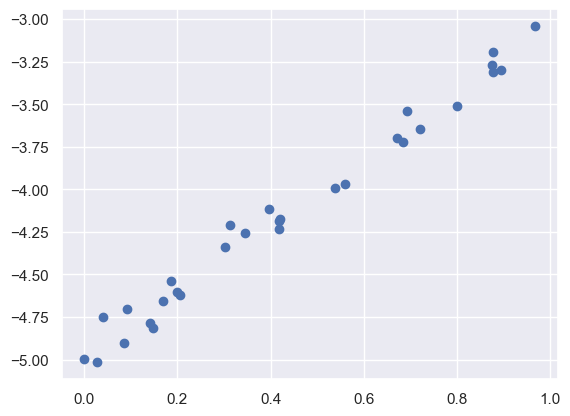

In [2]:
rng = np.random.RandomState(1)
x =  rng.rand(30)
y = 2 * x - 5 + 0.1* rng.randn(30)
plt.scatter(x, y);

Fill in the MultivariateLinearRegression class whose method fit takes a matrix $X$ and an array $y$ as input and returns an array of coefficients

In [3]:
class MultivariateLinearRegression():
    # Class for linear regression solving least-squares:

    def __init__(self,):
        self.coef_ = None
        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        # TODO :
        X_aug = np.c_[np.ones((X.shape[0])), X]
        
        
        # Update self.coef_
        self.coef_ = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ y
        
    def predict(self, X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        assert self.coef_ is not None, "Fit the model first!"
        X_aug = np.c_[np.ones((X.shape[0], 1)), X]
        y_predict = X_aug@self.coef_
        return  y_predict

Try your model on the data and plot the data points and the fitted line:

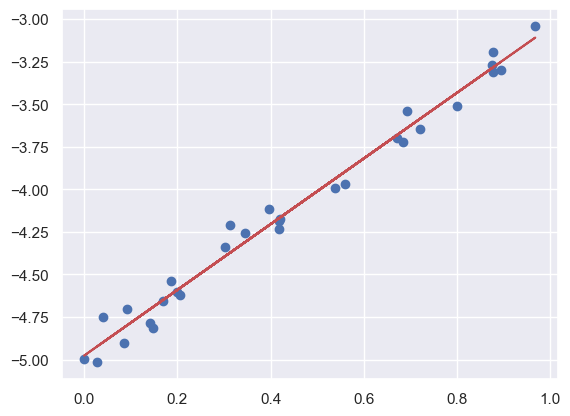

In [4]:
reg = MultivariateLinearRegression()
reg.fit(x, y)
y_predict = reg.predict(x)
plt.scatter(x, y)
plt.plot(x, y_predict, 'r-')
plt.show()


Print the scope and the intercept:

In [5]:
print(f"Model slope:  {reg.coef_[1]} ")
print(f"Model intercept: {reg.coef_[0]}")

Model slope:  1.9292055341290546 
Model intercept: -4.976046835178195


We see that the results are very close to the inputs, as we might hope.

Of course our linear regression estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building a toy example:

In [6]:
rng = np.random.RandomState(1)
X = 3 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])
model = MultivariateLinearRegression()
model.fit(X, y)
print(model.coef_) # perfect fitting

[ 0.5  1.5 -2.   1. ]


Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.

The idea is to take our multidimensional linear model:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \cdots
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

In [7]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(5, include_bias=False) # with or without intercept
poly.fit_transform(x[:, None])

array([[   2.,    4.,    8.,   16.,   32.],
       [   3.,    9.,   27.,   81.,  243.],
       [   4.,   16.,   64.,  256., 1024.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression

With this transform, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise:

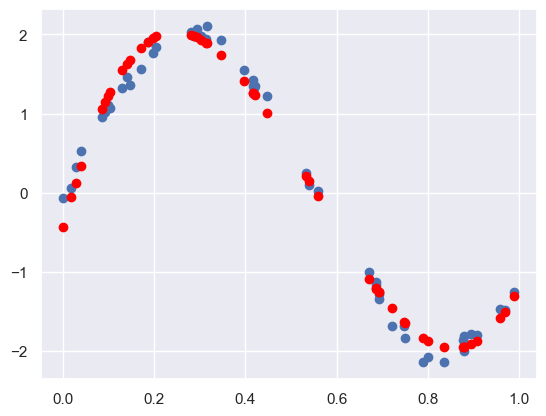

In [8]:
rng = np.random.RandomState(1)
x = rng.rand(50)
y = 2 * np.sin(1.8*np.pi*x) + 0.1 * rng.randn(50)
# 2 cloches = polynome degré 3 + sans intercept car déja implémenté dans le modèle
poly = PolynomialFeatures(3, include_bias=False)

x_poly = poly.fit_transform(x[:, None])
polynomial_model = MultivariateLinearRegression()
polynomial_model.fit(x_poly, y)
y_predict = polynomial_model.predict(x_poly)
plt.scatter(x, y)
plt.scatter(x, y_predict, color='red', label='Modèle polynomial')
plt.show()

Try with different maximum degrees. Our linear model can provide an excellent fit to this non-linear data!

**Bonus:** How can we avoid overfitting?

**Answer:**
Choose k using cross validation by splitting x into k folds and use k-1 folds as training and the last fold as validation to measure the generalization error

## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting.

With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data.
We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{i=1}^n \beta_i^2
$$
where $\alpha$ is a free parameter that controls the strength of the penalty.

 Fill in the following class:

In [9]:
class RidgeRegularization():
    # Class for ridge regression with closed form equation:

    def __init__(self, alpha):
        self.coef_ = None
        self.alpha_ = alpha
        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        # Create a (num_samples, num_features+1) np.array X_aug whose first column 
        # is a column of all ones (so as to fit an intercept).
        X_aug = np.c_[np.ones((X.shape[0])), X]
        
        # Update self.coef_ adding the shrinkage ridge term
        self.coef_ = (np.linalg.inv(X_aug.T @ X_aug + self.alpha_ * np.eye(X_aug.shape[1])) @ X_aug.T @ y)
        
    def predict(self, X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        assert self.coef_ is not None, "Fit the model first!"
        X_aug = np.c_[np.ones((X.shape[0])), X]
        y_pred = X_aug @ self.coef_
        return y_pred

Try the model in our data. Plot the coefficients of the regression.

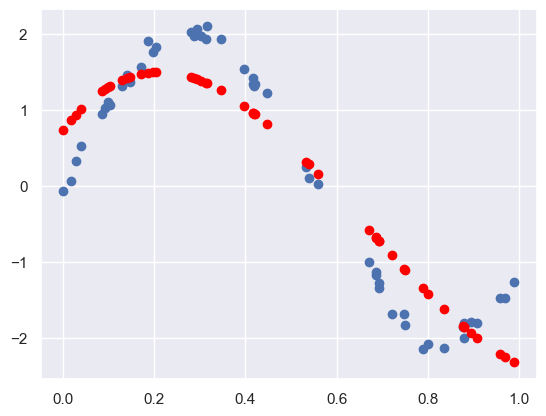

In [10]:
# TODO
# Ridge regression with alpha = 0.01
ridge = RidgeRegularization(alpha=0.01)
ridge.fit(x_poly, y)
y_predict = ridge.predict(x_poly)
plt.scatter(x, y)
plt.scatter(x, y_predict, color='red', label='Modèle polynomial')
plt.show()

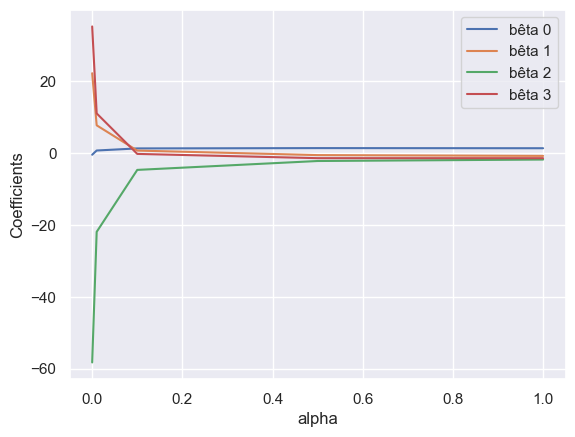

In [11]:
alpha_values = [0, 0.01, 0.1, 0.5, 1]
liste_params = []
for alpha in alpha_values:
    ridge = RidgeRegularization(alpha=alpha)
    ridge.fit(x_poly, y)
    coefs = ridge.coef_
    liste_params.append(coefs)

b0 = [liste_params[i][0] for i in range(len(alpha_values))]
b1 = [liste_params[i][1] for i in range(len(alpha_values))]
b2 = [liste_params[i][2] for i in range(len(alpha_values))]
b3 = [liste_params[i][3] for i in range(len(alpha_values))]
plt.plot(alpha_values, b0, label='bêta 0')
plt.plot(alpha_values, b1, label='bêta 1')
plt.plot(alpha_values, b2, label='bêta 2')
plt.plot(alpha_values, b3, label='bêta 3')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.legend()
plt.show()

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.

**Bonus:** How can we choose the $\alpha$ parameter?

**Answer:** 
Again, use k folds cross validation as we did for the choice of the degree of the polynomial 

### Lasso regression ($L_1$ Regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients: $$
P = \alpha\sum_{i=1}^n |\beta_i|$$ 
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients.

First, fill in the following class:

In [12]:
def soft_threshold(coefs, alpha, learning_rate):
    """Soft threshold function"""
    return np.sign(coefs) * np.maximum(np.abs(coefs) - learning_rate * alpha, 0)

class LassoRegularization:
    # Class for lasso regression with soft thresholding:

    def __init__(self, alpha, learning_rate=0.01, iterations=1000):
        self.coef_ = None
        self.alpha = alpha
        self.learning_rate_ = learning_rate
        self.iterations_ = iterations

    def fit(self, X, y):
        """Fit the data (X, y).
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_samples, ) np.array
            Output vector

        Note:
        -----
        Updates self.coef_
        """
        # Vérification des NaN dans les données
        if np.any(np.isnan(X)) or np.any(np.isnan(y)):
            raise ValueError("X and y should not contain NaN values.")
        
        # Augmenter X avec une colonne de 1 pour l'intercept
        X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
        
        # Initialisation des coefficients de manière aléatoire
        beta = np.random.randn(X_aug.shape[1])

        # Descente de coordonnées
        for i in range(self.iterations_):
            beta_transform = beta - self.learning_rate_ * (X_aug.T @ (X_aug @ beta - y))
            
            # Vérification des NaN dans beta_transform
            if np.any(np.isnan(beta_transform)):
                raise ValueError("NaN encountered in beta during iteration, adjust learning rate or check data.")
            
            beta = soft_threshold(beta_transform, self.alpha, self.learning_rate_)

            # Vérification des NaN dans beta après le soft thresholding
            if np.any(np.isnan(beta)):
                raise ValueError("NaN encountered in beta after soft thresholding.")
        
        self.coef_ = beta

    def predict(self, X):
        """Make predictions for data X.

        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix

        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        if self.coef_ is None:
            raise ValueError("The model has not been fitted yet.")
        
        X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
        return X_aug @ self.coef_

In [12]:
class LassoRegularization:
    # Class for lasso regression with soft thresholding:

    def __init__(self, alpha, learning_rate=0.01, iterations=1000):
        self.coef_ = None
        self.alpha_ = alpha
        self.learning_rate_ = learning_rate
        self.iterations_ = iterations
        
    def soft_threshold(self, val, alpha_):
        return np.sign(val) * np.maximum(np.abs(val) - alpha_, 0)
        
    def fit(self, X, y):
        """ Fit the data (X, y).
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """

        num_samples, num_features = X.shape
        X_aug = np.c_[np.ones(num_samples), X]
        self.coef_ = np.zeros(X_aug.shape[1])

        for iteration in range(self.iterations_):
            coef_old = self.coef_.copy()
            
            for j in range(num_features+1):
                # Compute the partial residual excluding the current feature j
                residuals = y - (X_aug @ self.coef_ - X_aug[:, j] * self.coef_[j])
                rho = X_aug[:, j].T @ residuals

                self.coef_[j] = self.soft_threshold(rho, self.alpha_) / np.sum(X_aug[:, j] ** 2)
            
            # Check convergence (based on the L2 norm of the difference in coefficients)
            if np.linalg.norm(self.coef_ - coef_old, ord=2) < self.learning_rate_:
                break

    def predict(self, X):
        """ Make predictions for data X.

        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        # TODO
        # return X @ self.coef_[1:] + self.coef_[0]

        X_aug = np.c_[np.ones(X.shape[0]), X]
        y_pred = X_aug @ self.coef_
        return y_pred

Try the model in our data. Plot the coefficients of the regression and compare them to the Ridge's coefficients.

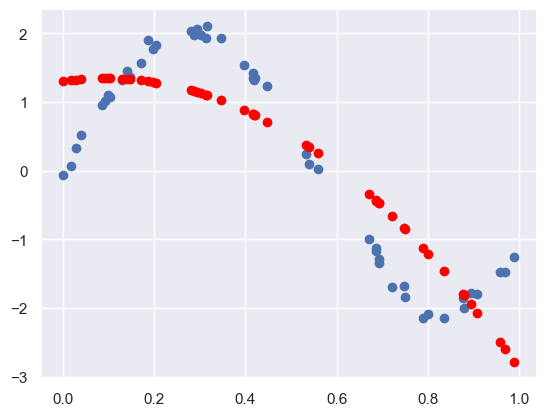

In [16]:
lasso = LassoRegularization(alpha=0)
lasso.fit(x_poly, y)
y_predict = lasso.predict(x_poly)
plt.scatter(x, y)
plt.scatter(x, y_predict, color='red', label='Modèle polynomial')
plt.show()

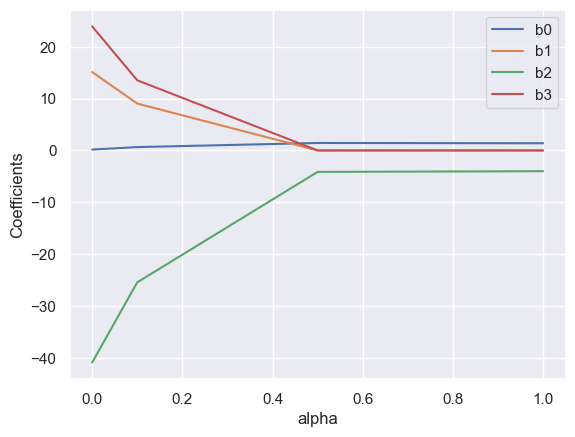

In [14]:
alpha_values = [0, 0.01, 0.1, 0.5, 1]
liste_params = []
for alpha in alpha_values:
    lasso = LassoRegularization(alpha=alpha)
    lasso.fit(x_poly, y)
    coefs = lasso.coef_
    liste_params.append(coefs)

b0 = [liste_params[i][0] for i in range(len(alpha_values))]
b1 = [liste_params[i][1] for i in range(len(alpha_values))]
b2 = [liste_params[i][2] for i in range(len(alpha_values))]
b3 = [liste_params[i][3] for i in range(len(alpha_values))]
plt.plot(alpha_values, b0, label='b0')
plt.plot(alpha_values, b1, label='b1')
plt.plot(alpha_values, b2, label='b2')
plt.plot(alpha_values, b3, label='b3')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.legend()
plt.show()

## Robust regression

Linear least-squares estimates can behave badly when the error distribution is not normal, particularly when
the errors are heavy-tailed. One remedy is to remove influential observations from the least-squares fit. Another approach, termed robust regression, is to employ a fitting criterion that is not as vulnerable as least squares to unusual data.

The most common general method of robust regression is M-estimation, introduced by Huber (1964).

Fill in the following class:

In [15]:
class RobustRegression:
    # Class for robust linear regression

    def __init__(self, potential='huber', k=1.5):
        self.coef_ = None
        self.potential_ = potential
        self.k_ = k

    def weight_function(self, x, potential, k):
        """ Calculate weight of point residual x.
    
        Parameters:
        -----------
        x: standarize by mad residual
        potential: name of the potential to use:
            "huber" or "bisquare"
        k: parameter of the potential function
        
        Returns:
        -----
        weight: weight corresponding to x 
        """
        if potential == "huber":
            return np.where(np.abs(x) <= k, 1, k / np.abs(x))
        elif potential == "bisquare":
            mask = np.abs(x) < k
            return np.where(mask, (1 - (x / k) ** 2) ** 2, 0)
        else:
            raise ValueError("Unknown potential function. Choose 'huber' or 'bisquare'.")

    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_samples, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """
        # Add intercept column of ones to X
        X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
        
        # Initial guess for coefficients
        self.coef_ = np.random.randn(X_aug.shape[1])
        
        # Iteratively update coefficients until convergence
        tol = 1e-6
        max_iter = 100
        for _ in range(max_iter):
            # Compute residuals
            residuals = y - X_aug @ self.coef_
            
            # Standardize residuals by median absolute deviation (MAD)
            mad = np.median(np.abs(residuals - np.median(residuals)))
            standardized_residuals = residuals / (mad + 1e-6)
            
            # Calculate weights using the weight function
            weights = self.weight_function(standardized_residuals, self.potential_, self.k_)
            W = np.diag(weights)
            
            # Update coefficients using weighted least squares
            XW = X_aug.T @ W @ X_aug
            XWy = X_aug.T @ W @ y
            coef_new = np.linalg.pinv(XW) @ XWy
            
            # Check for convergence
            if np.linalg.norm(self.coef_ - coef_new) < tol:
                break
            
            self.coef_ = coef_new

    def predict(self, X):
        """ Make predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions
        """
        # Add intercept to X
        X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
        return X_aug @ self.coef_

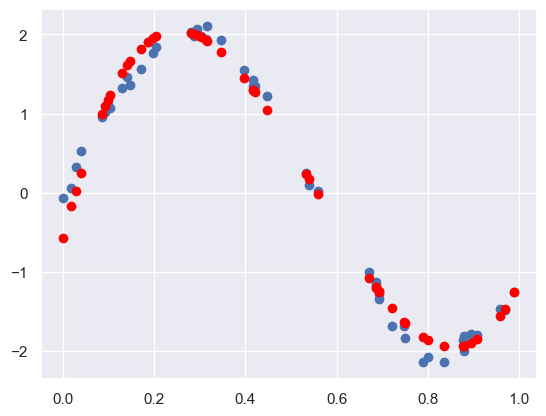

In [16]:
robust_reg = RobustRegression(potential='huber', k=1.5)
robust_reg.fit(x_poly, y)
y_predict = robust_reg.predict(x_poly)
plt.scatter(x, y)
plt.scatter(x, y_predict, color='red', label='Modèle polynomial')
plt.show()

Try it in the following data with outliers coming from the heavy-tail error and compare with the performance of the other models:

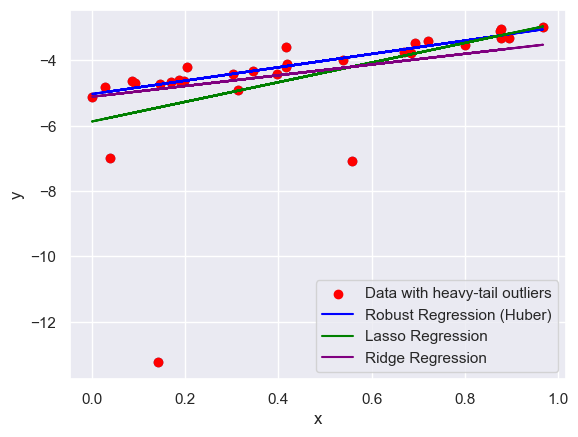

In [17]:
np.random.seed(300)
rng = np.random.RandomState(1)
x =  rng.rand(30)
y = 2 * x - 5 + 0.1* np.random.standard_cauchy(30)
plt.scatter(x, y);

# Initialiser les modèles
robust_model = RobustRegression(potential='huber', k=1.5)
lasso_model = LassoRegularization(alpha=0.1, learning_rate=0.01, iterations=1000)
ridge_model = RidgeRegularization(alpha=1)

# Ajuster les modèles aux données
x = x.reshape(-1, 1)
robust_model.fit(x, y)
lasso_model.fit(x, y)
ridge_model.fit(x, y)

# Faire des prédictions
y_pred_robust = robust_model.predict(x)
y_pred_lasso = lasso_model.predict(x)
y_pred_ridge = ridge_model.predict(x)


# Visualiser les prédictions des modèles
plt.scatter(x, y, color='red', label='Data with heavy-tail outliers')
plt.plot(x, y_pred_robust, color='blue', label='Robust Regression (Huber)')
plt.plot(x, y_pred_lasso, color='green', label='Lasso Regression')
plt.plot(x, y_pred_ridge, color='purple', label='Ridge Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Bonus: Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

In this section, we joinned the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.

As you may now, we should use time series techniques to analyze this dataset, instead, as a first simple approach, we will perform a multivariate linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

Let's start by loading the dataset:

In [18]:
import pandas as pd
daily = pd.read_csv('data.csv', parse_dates=True)
daily.describe()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
count,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,2633.284774,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.027256,11.992905,0.115446,12.567528,0.584586,1.456164
std,1252.570814,0.350092,0.350092,0.350092,0.350092,0.350092,0.350092,0.350092,0.162904,2.644046,0.259009,6.094262,0.493025,0.841903
min,98.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.218894,0.000000,-3.800000,0.000000,0.000000
25%,1807.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.404678,0.000000,8.050000,0.000000,0.728082
50%,2439.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.952145,0.000000,11.675000,1.000000,1.456164
75%,3568.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.601222,0.101378,17.750000,1.000000,2.184247
max,6088.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.781095,2.200787,26.700000,1.000000,2.912329


With this in place, we can choose the columns to use, and fit a linear regression model to our data:

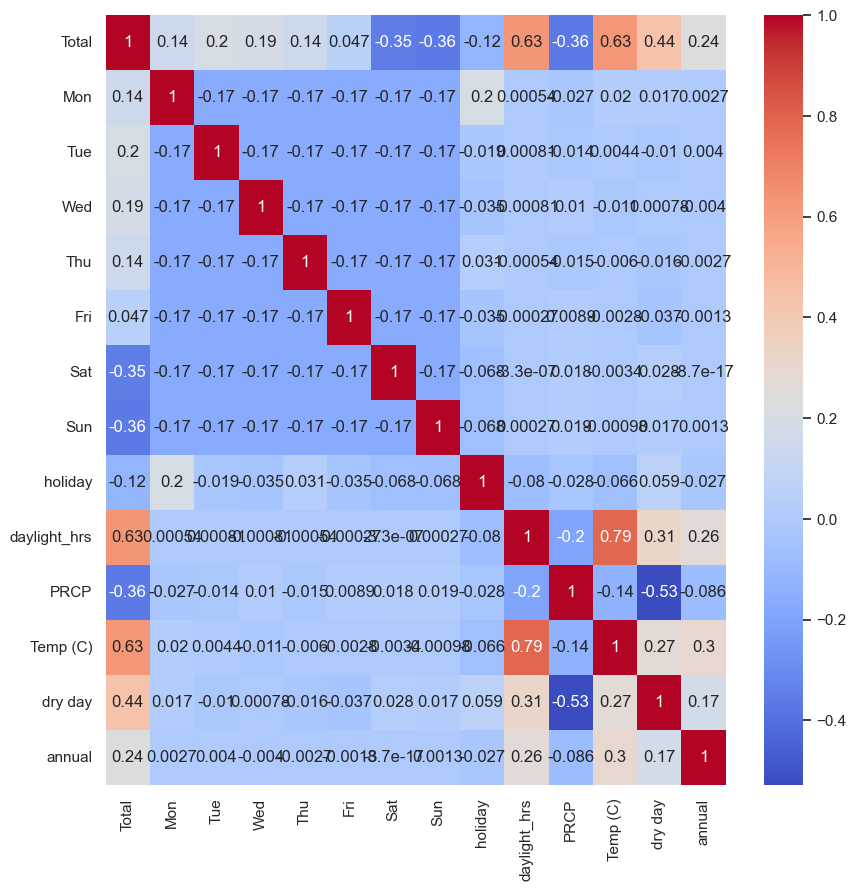

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Drop any rows with null values

daily.dropna(inplace=True)

# Apply the previous algorithms to fit the number of bicycles
# Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(daily.drop("Date", axis=1).corr(), annot=True, cmap="coolwarm")
# Pipeline de transformation
x = daily.drop(
    ["Total", "Date", "daylight_hrs"], axis=1
)  # Les var daylight et temp sont corrélées
y = daily["Total"]

numeric_transformer = Pipeline(steps=[("scaler", MinMaxScaler())])
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, x.columns)],
    remainder="passthrough",  # Garder les autres colonnes telles quelles
)
x_preprocessed = preprocessor.fit_transform(x)

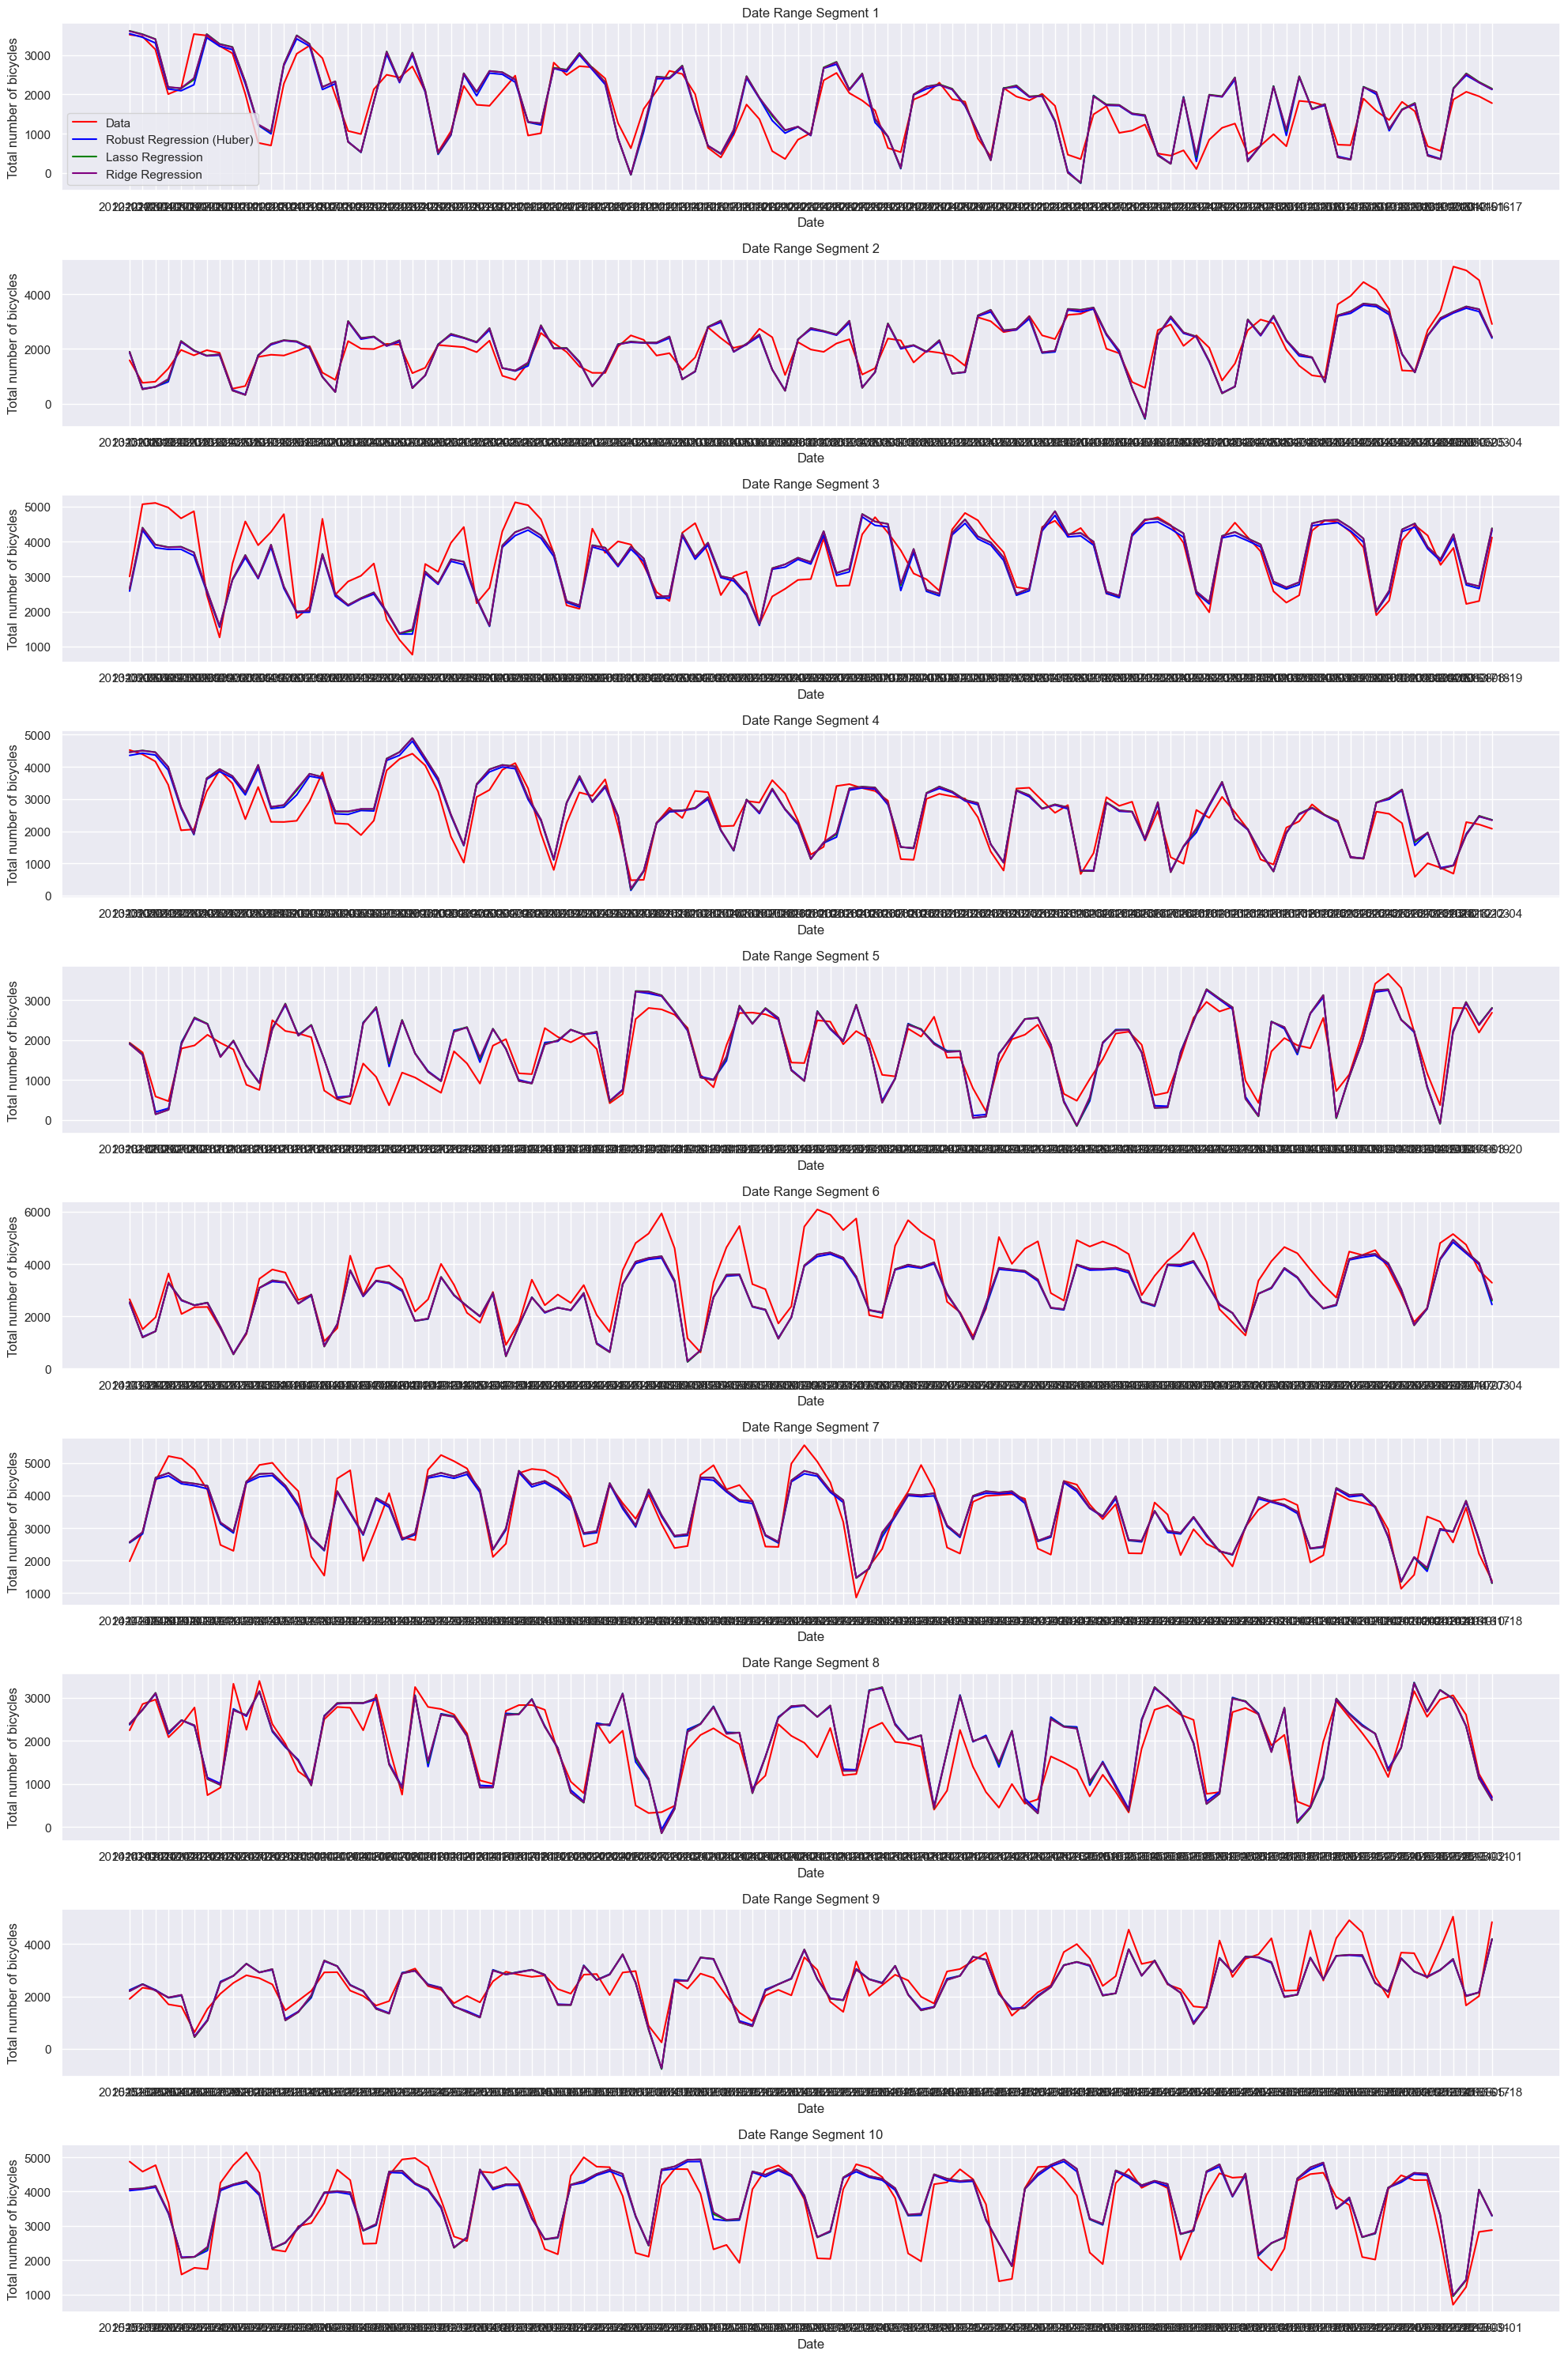

In [20]:
robust_model = RobustRegression(potential="huber", k=1.5)
lasso_model = LassoRegularization(alpha=0.1, learning_rate=0.01, iterations=1000)
ridge_model = RidgeRegularization(alpha=1)
robust_model.fit(x, y)
lasso_model.fit(x, y)
ridge_model.fit(x, y)
y_pred_robust = robust_model.predict(x)
y_pred_lasso = lasso_model.predict(x)
y_pred_ridge = ridge_model.predict(x)

# Définition des segments de dates
segments = np.array_split(daily["Date"].unique(), 10)

plt.figure(figsize=(20, 30))

# Tracer les 10 sous-graphes avec les 3 modèles de régression sur le même graphe pour chaque segment de date
for i, segment_dates in enumerate(segments):
    segment_mask = daily["Date"].isin(segment_dates)
    
    # Extraction des données segmentées pour chaque sous-graphe
    date_segment = daily["Date"][segment_mask]
    y_segment = y[segment_mask]
    y_pred_robust_segment = y_pred_robust[segment_mask]
    y_pred_lasso_segment = y_pred_lasso[segment_mask]
    y_pred_ridge_segment = y_pred_ridge[segment_mask]

    # Création du sous-graphe
    plt.subplot(10, 1, i + 1)
    plt.plot(date_segment, y_segment, color="red", label="Data")
    plt.plot(date_segment, y_pred_robust_segment, color="blue", label="Robust Regression (Huber)")
    plt.plot(date_segment, y_pred_lasso_segment, color="green", label="Lasso Regression")
    plt.plot(date_segment, y_pred_ridge_segment, color="purple", label="Ridge Regression")
    plt.xlabel("Date")
    plt.ylabel("Total number of bicycles")
    plt.title(f"Date Range Segment {i + 1}")
    
    # Afficher la légende uniquement pour le premier sous-graphe
    if i == 0:
        plt.legend()

# Affichage des figures avec un espacement entre les sous-graphes
plt.tight_layout()
plt.show()


Finally, we can compare the total and predicted bicycle traffic visually:

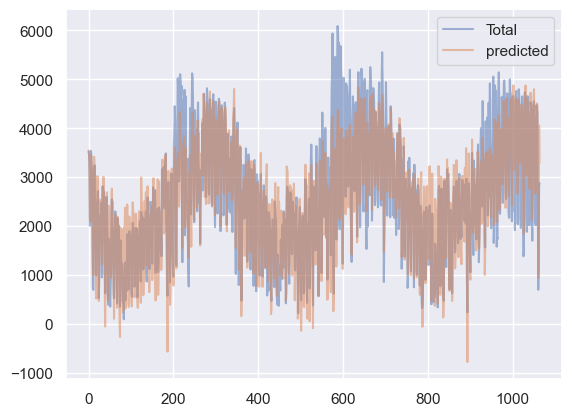

In [21]:
daily['predicted'] = y_pred_robust
daily[['Total', 'predicted']].plot(alpha=0.5);

It is evident that we have missed some key features, especially during the summer time.
Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).